# INTEGRATE timing
This notebook compares CPU time using for both forward mdoeling and inversion 

# Force use of single CPU with numpy
export OMP_NUM_THREADS=1
export MKL_NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1


In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # # # # # #%load_ext autoreload
    # # # # # # # # # #%autoreload 2
    pass

In [2]:
import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import loglog
import time
import h5py
# get name of CPU
import os
import socket

# Get hostanme and number of processors
hostname = socket.gethostname()
Ncpu_total = os.cpu_count()
print("Hostname: %s" % hostname)
print("Number of processors: %d" % Ncpu_total)

Notebook detected. Parallel processing is OK
Hostname: d60897
Number of processors: 10


## Get the default data set

In [3]:
files = ig.get_case_data()
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)

print("Using data file: %s" % f_data_h5)
print("Using GEX file: %s" % file_gex)

with h5py.File(f_data_h5, 'r') as f:
    nobs = f['D1/d_obs'].shape[0]

Getting data for case: DAUGAARD
--> Got data for case: DAUGAARD
Using data file: DAUGAARD_AVG.h5
Using GEX file: TX07_20231016_2x4_RC20-33.gex


## Setup the timing test

In [4]:
#### Set the size of the data sets to test
N_arr = np.array([100,500,1000,5000,10000,50000,100000, 500000, 1000000])
N_arr = np.array([100,1000,10000,100000])

# Set the number of cores to test
#Nproc_arr=2**(np.double(np.arange(1+int(np.log2(Ncpu_total)))))
Nproc_arr=2**(1+np.double(np.arange(int(np.log2(Ncpu_total)))))

useAltTest=True
if useAltTest:
    N_arr = np.array([100,500,1000,5000,10000,50000,100000])
    N_arr = np.array([100,500,1000,5000,10000,50000,100000])
    
    skip_proc = 0
    Nproc_arr=2**(np.double(skip_proc+np.arange(1+int(np.log2(Ncpu_total)))))
    #Nproc_arr=2**(np.double(skip_proc+np.arange(int(np.log2(Ncpu_total)))))
    ##Nproc_arr=np.arange(2, Ncpu_total/2+1, 2)
    #Nproc_arr=np.append(Nproc_arr,np.arange(10,1+Ncpu_total/2,2))
    #Nproc_arr=np.array([1,4,8])

    N_arr = np.array([500,600,700,800,900,1000])
    Nproc_arr=np.array([2,3,4,5,6,7,8])
    

n1 = len(N_arr)
n2 = len(Nproc_arr)


print("Testing on %d data sets of sizes" % n1)
print(N_arr)
print("Testing on %d sets of cores" % n2)
print(Nproc_arr)


file_out  = 'timing_%s-%d_Nproc%d_N%d' % (hostname,Ncpu_total,len(Nproc_arr), len(N_arr))
print("Writing results to %s " % file_out)

Testing on 6 data sets of sizes
[ 500  600  700  800  900 1000]
Testing on 7 sets of cores
[2 3 4 5 6 7 8]
Writing results to timing_d60897-10_Nproc7_N6 


## Run INTEGRATE workflow using different data sizes and number of CPUS

In [5]:

loadFromFile=False
if loadFromFile:
    file_out = 'timing_3990X-64_Nproc7_N9'  
    file_out = 'timing_3990X-64_Nproc35_N8' 
    file_out = 'timing_d60897-10_Nproc3_N5'
    
    #file_out = 'timing_d52534-32_Nproc13_N9'
    #file_out = 'timing_d52534-32_Nproc6_N9'  
    #file_out = 'timing_d52534-32_Nproc17_N9'
    #file_out = 'timing_d52534-32_Nproc13_N9-issue16'
    
    #file_out = 'timing_Z13-16_Nproc8_N7'
    
    data = np.load('%s.npz' % file_out)
    T_prior = data['T_prior']
    T_forward = data['T_forward']
    T_rejection = data['T_rejection']
    T_poststat = data['T_poststat']

    T_total = T_prior + T_forward + T_rejection + T_poststat

    N_arr = data['N_arr']
    Nproc_arr = data['Nproc_arr']
    try:
        nobs=data['nobs']
    except:
        nobs=11693

else:

    showInfo = 0

    T_prior = np.zeros((n1,n2))*np.nan
    T_forward = np.zeros((n1,n2))*np.nan
    T_rejection = np.zeros((n1,n2))*np.nan
    T_poststat = np.zeros((n1,n2))*np.nan

    testRejection = True
    testPostStat = True  
                
    for j in np.arange(n2):
        Ncpu = int(Nproc_arr[j])
        
        t_prior = []
        t_forward  = []
        t_rejection = []
        t_poststat = []

        for i in np.arange(len(N_arr)):
            N=int(N_arr[i])
            Ncpu_min = int(np.floor(2**(np.log10(N)-4)))
            
            #print('=====================================================')
            print('N=%d, Ncpu=%d, Ncpu_min=%d'%(N,Ncpu,Ncpu_min))

            RHO_min = 1
            RHO_max = 800
            z_max = 50 
            useP = 1
            
            if (Ncpu>=Ncpu_min):
                    
                t0_prior = time.time()
                if useP ==1:
                    ## Layered model    
                    f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='chi2', NLAY_deg=5, z_max = z_max, RHO_dist='log-uniform', RHO_min=RHO_min, RHO_max=RHO_max, showInfo=showInfo)
                    #f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='uniform', z_max = z_max, NLAY_min=1, NLAY_max=3, rho_dist='log-uniform', RHO_min=RHO_min, RHO_max=RHO_max)
                    #f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='uniform', z_max = z_max, NLAY_min=1, NLAY_max=8, rho_dist='log-uniform', RHO_min=RHO_min, RHO_max=RHO_max)
                else: 
                    ## N layer model with increasing thickness
                    f_prior_h5 = ig.prior_model_workbench(N=N, z_max = 30, nlayers=20, rho_min = RHO_min, rho_max = RHO_max, showInfo=showInfo)
                #t_prior.append(time.time()-t0_prior)
                T_prior[i,j] = time.time()-t0_prior

            
                #ig.plot_prior_stats(f_prior_h5)
                #% A2. Compute prior DATA
                t0_forward = time.time()
                f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex, Ncpu=Ncpu, showInfo=showInfo)
                T_forward[i,j]=time.time()-t0_forward

                #% READY FOR INVERSION
                N_use = 1000000
                t0_rejection = time.time()
                if testRejection:
                    f_post_h5 = ig.integrate_rejection(f_prior_data_h5, f_data_h5, N_use = N_use, parallel=1, updatePostStat=False,  Ncpu=Ncpu, showInfo=showInfo)
                T_rejection[i,j]=time.time()-t0_rejection

                #% Compute some generic statistic of the posterior distribution (Mean, Median, Std)
                t0_poststat = time.time()
                if testPostStat and testRejection:
                    ig.integrate_posterior_stats(f_post_h5,showInfo=showInfo)
                    T_poststat[i,j]=time.time()-t0_poststat

            T_total = T_prior + T_forward + T_rejection + T_poststat
            np.savez(file_out, T_total=T_total, T_prior=T_prior, T_forward=T_forward, T_rejection=T_rejection, T_poststat=T_poststat, N_arr=N_arr, Nproc_arr=Nproc_arr, nobs=nobs)



N=500, Ncpu=2, Ncpu_min=0


True
prior_data_gaaem: Using 2 parallel threads.


gatdaem1d:  73%|███████▎  | 183/250 [00:03<00:01, 58.50it/s]

prior_data_gaaem: Time=  4.8s/500 soundings.  9.7ms/sounding, 103.5it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8524.4it/s
integrate_rejection: T_av=704.5


N=600, Ncpu=2, Ncpu_min=0


True
prior_data_gaaem: Using 2 parallel threads.


gatdaem1d:  92%|█████████▏| 277/300 [00:04<00:00, 67.72it/s]

prior_data_gaaem: Time=  5.1s/600 soundings.  8.4ms/sounding, 118.7it/s


integrate_rejection: Time=  1.5s/11693 soundings,  0.1ms/sounding, 7819.8it/s
integrate_rejection: T_av=545.1


N=700, Ncpu=2, Ncpu_min=0


True
prior_data_gaaem: Using 2 parallel threads.


prior_data_gaaem: Time=  6.0s/700 soundings.  8.5ms/sounding, 117.1it/s


integrate_rejection: Time=  1.5s/11693 soundings,  0.1ms/sounding, 7592.9it/s
integrate_rejection: T_av=616.8


N=800, Ncpu=2, Ncpu_min=0


True
prior_data_gaaem: Using 2 parallel threads.


prior_data_gaaem: Time=  6.6s/800 soundings.  8.3ms/sounding, 121.0it/s


integrate_rejection: Time=  1.6s/11693 soundings,  0.1ms/sounding, 7262.6it/s
integrate_rejection: T_av=521.0


N=900, Ncpu=2, Ncpu_min=0


True
prior_data_gaaem: Using 2 parallel threads.


gatdaem1d:  93%|█████████▎| 418/450 [00:06<00:00, 67.06it/s]

prior_data_gaaem: Time=  7.3s/900 soundings.  8.1ms/sounding, 123.0it/s


integrate_rejection: Time=  1.7s/11693 soundings,  0.1ms/sounding, 6899.6it/s
integrate_rejection: T_av=486.1


N=1000, Ncpu=2, Ncpu_min=0


True
prior_data_gaaem: Using 2 parallel threads.


gatdaem1d:  94%|█████████▍| 470/500 [00:07<00:00, 66.46it/s]

prior_data_gaaem: Time=  8.2s/1000 soundings.  8.2ms/sounding, 121.7it/s


integrate_rejection: Time=  1.8s/11693 soundings,  0.1ms/sounding, 6668.3it/s
integrate_rejection: T_av=451.2


N=500, Ncpu=3, Ncpu_min=0


True
prior_data_gaaem: Using 3 parallel threads.


gatdaem1d:  77%|███████▋  | 128/167 [00:02<00:00, 61.78it/s]

prior_data_gaaem: Time=  3.4s/500 soundings.  6.7ms/sounding, 148.2it/s


integrate_rejection: Time=  1.2s/11693 soundings,  0.1ms/sounding, 9860.3it/s
integrate_rejection: T_av=620.3


N=600, Ncpu=3, Ncpu_min=0


True
prior_data_gaaem: Using 3 parallel threads.


prior_data_gaaem: Time=  3.9s/600 soundings.  6.5ms/sounding, 153.4it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 9100.0it/s
integrate_rejection: T_av=556.5


N=700, Ncpu=3, Ncpu_min=0


True
prior_data_gaaem: Using 3 parallel threads.


gatdaem1d:  82%|████████▏ | 191/234 [00:03<00:00, 61.64it/s]

prior_data_gaaem: Time=  4.5s/700 soundings.  6.4ms/sounding, 156.0it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 8719.6it/s
integrate_rejection: T_av=478.5


N=800, Ncpu=3, Ncpu_min=0


True
prior_data_gaaem: Using 3 parallel threads.


prior_data_gaaem: Time=  5.0s/800 soundings.  6.3ms/sounding, 158.5it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8627.5it/s
integrate_rejection: T_av=485.5


N=900, Ncpu=3, Ncpu_min=0


True
prior_data_gaaem: Using 3 parallel threads.


gatdaem1d:  86%|████████▌ | 258/300 [00:04<00:00, 62.90it/s]

prior_data_gaaem: Time=  5.5s/900 soundings.  6.1ms/sounding, 164.0it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8138.2it/s
integrate_rejection: T_av=503.7


N=1000, Ncpu=3, Ncpu_min=0


True
prior_data_gaaem: Using 3 parallel threads.


gatdaem1d:  92%|█████████▏| 306/333 [00:05<00:00, 60.47it/s]

prior_data_gaaem: Time=  6.3s/1000 soundings.  6.3ms/sounding, 159.3it/s


integrate_rejection: Time=  1.5s/11693 soundings,  0.1ms/sounding, 7924.6it/s
integrate_rejection: T_av=375.5


N=500, Ncpu=4, Ncpu_min=0


True
prior_data_gaaem: Using 4 parallel threads.


gatdaem1d:  48%|████▊     | 60/125 [00:01<00:01, 59.01it/s]

prior_data_gaaem: Time=  2.8s/500 soundings.  5.6ms/sounding, 178.4it/s


integrate_rejection: Time=  1.2s/11693 soundings,  0.1ms/sounding, 9549.3it/s
integrate_rejection: T_av=783.7


N=600, Ncpu=4, Ncpu_min=0


True
prior_data_gaaem: Using 4 parallel threads.


prior_data_gaaem: Time=  3.3s/600 soundings.  5.5ms/sounding, 180.7it/s


integrate_rejection: Time=  1.2s/11693 soundings,  0.1ms/sounding, 9788.5it/s
integrate_rejection: T_av=581.3


N=700, Ncpu=4, Ncpu_min=0


True
prior_data_gaaem: Using 4 parallel threads.


gatdaem1d:  72%|███████▏  | 126/175 [00:02<00:00, 61.24it/s]

prior_data_gaaem: Time=  3.6s/700 soundings.  5.2ms/sounding, 193.3it/s


integrate_rejection: Time=  1.2s/11693 soundings,  0.1ms/sounding, 9390.7it/s
integrate_rejection: T_av=500.6


N=800, Ncpu=4, Ncpu_min=0


True
prior_data_gaaem: Using 4 parallel threads.


gatdaem1d:  90%|█████████ | 180/200 [00:03<00:00, 59.74it/s]

prior_data_gaaem: Time=  4.1s/800 soundings.  5.2ms/sounding, 194.0it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 8707.0it/s
integrate_rejection: T_av=498.1


N=900, Ncpu=4, Ncpu_min=0


True
prior_data_gaaem: Using 4 parallel threads.


gatdaem1d:  82%|████████▏ | 185/225 [00:03<00:00, 61.29it/s]

prior_data_gaaem: Time=  4.4s/900 soundings.  4.9ms/sounding, 203.1it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 8906.6it/s
integrate_rejection: T_av=450.9


N=1000, Ncpu=4, Ncpu_min=0


True
prior_data_gaaem: Using 4 parallel threads.


prior_data_gaaem: Time=  5.0s/1000 soundings.  5.0ms/sounding, 201.2it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8660.6it/s
integrate_rejection: T_av=430.8


N=500, Ncpu=5, Ncpu_min=0


True
prior_data_gaaem: Using 5 parallel threads.


gatdaem1d:  56%|█████▌    | 56/100 [00:01<00:00, 55.36it/s]

prior_data_gaaem: Time=  2.8s/500 soundings.  5.5ms/sounding, 180.6it/s


integrate_rejection: Time=  1.2s/11693 soundings,  0.1ms/sounding, 9482.6it/s
integrate_rejection: T_av=799.1


N=600, Ncpu=5, Ncpu_min=0


True
prior_data_gaaem: Using 5 parallel threads.


prior_data_gaaem: Time=  3.1s/600 soundings.  5.2ms/sounding, 191.9it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 8905.6it/s
integrate_rejection: T_av=621.6


N=700, Ncpu=5, Ncpu_min=0


True
prior_data_gaaem: Using 5 parallel threads.


prior_data_gaaem: Time=  3.5s/700 soundings.  5.0ms/sounding, 200.0it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8639.5it/s
integrate_rejection: T_av=558.5


N=800, Ncpu=5, Ncpu_min=0


True
prior_data_gaaem: Using 5 parallel threads.


gatdaem1d:  69%|██████▉   | 110/160 [00:02<00:00, 53.03it/s]

prior_data_gaaem: Time=  4.4s/800 soundings.  5.5ms/sounding, 181.8it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8507.6it/s
integrate_rejection: T_av=471.0


N=900, Ncpu=5, Ncpu_min=0


True
prior_data_gaaem: Using 5 parallel threads.


prior_data_gaaem: Time=  4.2s/900 soundings.  4.7ms/sounding, 212.8it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 8992.1it/s
integrate_rejection: T_av=528.7


N=1000, Ncpu=5, Ncpu_min=0


True
prior_data_gaaem: Using 5 parallel threads.


prior_data_gaaem: Time=  4.5s/1000 soundings.  4.5ms/sounding, 220.4it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8632.6it/s
integrate_rejection: T_av=453.2


N=500, Ncpu=6, Ncpu_min=0


True
prior_data_gaaem: Using 6 parallel threads.


gatdaem1d:  58%|█████▊    | 48/83 [00:01<00:00, 47.58it/s]

prior_data_gaaem: Time=  2.9s/500 soundings.  5.8ms/sounding, 173.1it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8540.5it/s
integrate_rejection: T_av=739.9


N=600, Ncpu=6, Ncpu_min=0


True
prior_data_gaaem: Using 6 parallel threads.


prior_data_gaaem: Time=  3.1s/600 soundings.  5.1ms/sounding, 196.3it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 9047.7it/s
integrate_rejection: T_av=541.2


N=700, Ncpu=6, Ncpu_min=0


True
prior_data_gaaem: Using 6 parallel threads.


prior_data_gaaem: Time=  4.2s/700 soundings.  6.0ms/sounding, 165.4it/s


integrate_rejection: Time=  1.9s/11693 soundings,  0.2ms/sounding, 6153.6it/s
integrate_rejection: T_av=539.8


N=800, Ncpu=6, Ncpu_min=0


True
prior_data_gaaem: Using 6 parallel threads.


gatdaem1d:  70%|███████   | 94/134 [00:02<00:00, 46.20it/s]

prior_data_gaaem: Time=  4.0s/800 soundings.  5.0ms/sounding, 201.5it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8342.0it/s
integrate_rejection: T_av=530.2


N=900, Ncpu=6, Ncpu_min=0


True
prior_data_gaaem: Using 6 parallel threads.


prior_data_gaaem: Time=  4.2s/900 soundings.  4.6ms/sounding, 215.2it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 8664.1it/s
integrate_rejection: T_av=459.0


N=1000, Ncpu=6, Ncpu_min=0


True
prior_data_gaaem: Using 6 parallel threads.


prior_data_gaaem: Time=  4.6s/1000 soundings.  4.6ms/sounding, 218.8it/s


integrate_rejection: Time=  1.5s/11693 soundings,  0.1ms/sounding, 8052.5it/s
integrate_rejection: T_av=423.6


N=500, Ncpu=7, Ncpu_min=0


True
prior_data_gaaem: Using 7 parallel threads.


gatdaem1d:  65%|██████▌   | 47/72 [00:01<00:00, 45.58it/s]

prior_data_gaaem: Time=  2.7s/500 soundings.  5.4ms/sounding, 186.4it/s


integrate_rejection: Time=  1.3s/11693 soundings,  0.1ms/sounding, 9352.8it/s
integrate_rejection: T_av=728.5


N=600, Ncpu=7, Ncpu_min=0


True
prior_data_gaaem: Using 7 parallel threads.


gatdaem1d:  55%|█████▍    | 47/86 [00:01<00:00, 46.04it/s]

prior_data_gaaem: Time=  2.9s/600 soundings.  4.9ms/sounding, 203.4it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8619.0it/s
integrate_rejection: T_av=608.5


N=700, Ncpu=7, Ncpu_min=0


True
prior_data_gaaem: Using 7 parallel threads.


prior_data_gaaem: Time=  3.3s/700 soundings.  4.7ms/sounding, 213.8it/s


integrate_rejection: Time=  1.5s/11693 soundings,  0.1ms/sounding, 7586.8it/s
integrate_rejection: T_av=555.7


N=800, Ncpu=7, Ncpu_min=0


True
prior_data_gaaem: Using 7 parallel threads.


prior_data_gaaem: Time=  3.7s/800 soundings.  4.6ms/sounding, 217.1it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8355.0it/s
integrate_rejection: T_av=536.9


N=900, Ncpu=7, Ncpu_min=0


True
prior_data_gaaem: Using 7 parallel threads.


gatdaem1d:  73%|███████▎  | 94/128 [00:02<00:00, 46.55it/s]]

prior_data_gaaem: Time=  3.6s/900 soundings.  3.9ms/sounding, 253.3it/s


integrate_rejection: Time=  1.5s/11693 soundings,  0.1ms/sounding, 7592.8it/s
integrate_rejection: T_av=460.1


N=1000, Ncpu=7, Ncpu_min=0


True
prior_data_gaaem: Using 7 parallel threads.


gatdaem1d:  71%|███████▏  | 102/143 [00:02<00:00, 46.91it/s]

prior_data_gaaem: Time=  4.1s/1000 soundings.  4.1ms/sounding, 244.2it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8365.6it/s
integrate_rejection: T_av=432.6


N=500, Ncpu=8, Ncpu_min=0


True
prior_data_gaaem: Using 8 parallel threads.


gatdaem1d:  71%|███████▏  | 45/63 [00:01<00:00, 44.10it/s]

prior_data_gaaem: Time=  2.4s/500 soundings.  4.8ms/sounding, 207.8it/s


integrate_rejection: Time=  1.4s/11693 soundings,  0.1ms/sounding, 8187.5it/s
integrate_rejection: T_av=638.7


N=600, Ncpu=8, Ncpu_min=0


True
prior_data_gaaem: Using 8 parallel threads.


prior_data_gaaem: Time=  2.9s/600 soundings.  4.8ms/sounding, 208.7it/s


integrate_rejection: Time=  1.6s/11693 soundings,  0.1ms/sounding, 7339.7it/s
integrate_rejection: T_av=701.0


N=700, Ncpu=8, Ncpu_min=0


True
prior_data_gaaem: Using 8 parallel threads.


prior_data_gaaem: Time=  3.2s/700 soundings.  4.5ms/sounding, 219.8it/s


integrate_rejection: Time=  1.6s/11693 soundings,  0.1ms/sounding, 7306.4it/s
integrate_rejection: T_av=518.8


N=800, Ncpu=8, Ncpu_min=0


True
prior_data_gaaem: Using 8 parallel threads.


prior_data_gaaem: Time=  3.6s/800 soundings.  4.5ms/sounding, 222.8it/s


integrate_rejection: Time=  1.7s/11693 soundings,  0.1ms/sounding, 6756.8it/s
integrate_rejection: T_av=507.7


N=900, Ncpu=8, Ncpu_min=0


True
prior_data_gaaem: Using 8 parallel threads.


gatdaem1d:  86%|████████▌ | 96/112 [00:02<00:00, 45.36it/s]

prior_data_gaaem: Time=  3.6s/900 soundings.  4.0ms/sounding, 247.2it/s


integrate_rejection: Time=  1.7s/11693 soundings,  0.1ms/sounding, 6780.2it/s
integrate_rejection: T_av=435.0


N=1000, Ncpu=8, Ncpu_min=0


True
prior_data_gaaem: Using 8 parallel threads.


prior_data_gaaem: Time=  4.0s/1000 soundings.  4.0ms/sounding, 251.3it/s


integrate_rejection: Time=  1.5s/11693 soundings,  0.1ms/sounding, 7980.0it/s
integrate_rejection: T_av=455.4


In [6]:
# LSQ, Assumed time, in seconds, for least squares inversion of a single sounding
t_lsq = 2.0
# SAMPLING, Assumed time, in seconds, for an McMC inversion of a single sounding
t_mcmc = 10.0*60.0 

total_lsq = np.array([nobs*t_lsq, nobs*t_lsq/Nproc_arr[-1]])
total_mcmc = np.array([nobs*t_mcmc, nobs*t_mcmc/Nproc_arr[-1]])

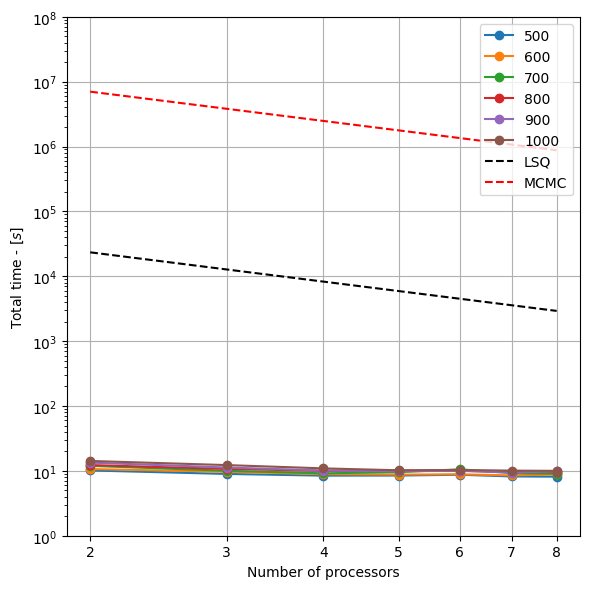

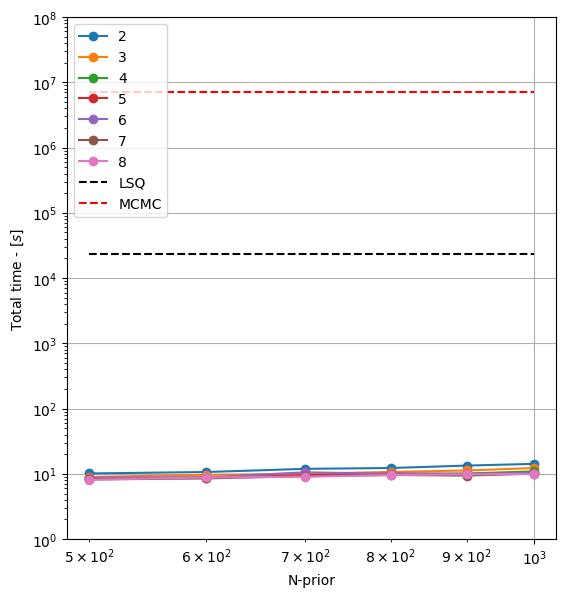

In [7]:
plt.figure(figsize=(6,6))    
plt.loglog(Nproc_arr, T_total.T, 'o-',  label=N_arr)
plt.ylabel(r'Total time - $[s]$')
plt.xlabel('Number of processors')
plt.grid()
total_lsq = np.array([nobs*t_lsq, nobs*t_lsq/Nproc_arr[-1]])
plt.plot([Nproc_arr[0], Nproc_arr[-1]], total_lsq, 'k--', label='LSQ')
plt.plot([Nproc_arr[0], Nproc_arr[-1]], total_mcmc, 'r--', label='MCMC')
plt.legend(loc='upper right')
plt.xticks(ticks=Nproc_arr, labels=[str(int(x)) for x in Nproc_arr])
plt.ylim(1,1e+8)
plt.tight_layout()
plt.savefig('%s_total_sec' % file_out)

plt.figure(figsize=(6,6)) 
plt.loglog(N_arr, T_total, 'o-', label=[f'{int(x)}' for x in Nproc_arr])
plt.ylabel(r'Total time - $[s]$')
plt.xlabel('N-prior')
plt.grid()
plt.tight_layout()
plt.plot([N_arr[0], N_arr[-1]], [nobs*t_lsq, nobs*t_lsq], 'k--', label='LSQ')
plt.plot([N_arr[0], N_arr[-1]], [nobs*t_mcmc, nobs*t_mcmc], 'r--', label='MCMC')
plt.legend(loc='upper left')
#plt.xticks(ticks=N_arr, labels=[str(int(x)) for x in Nproc_arr])
plt.ylim(1,1e+8)
plt.savefig('%s_total_sec' % file_out)



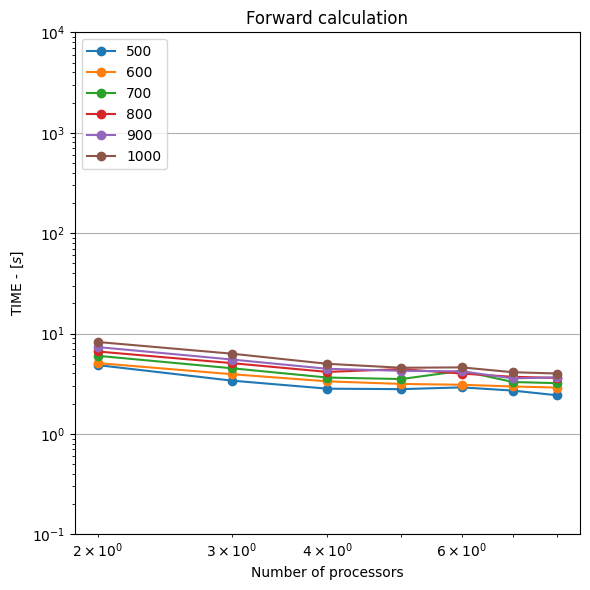

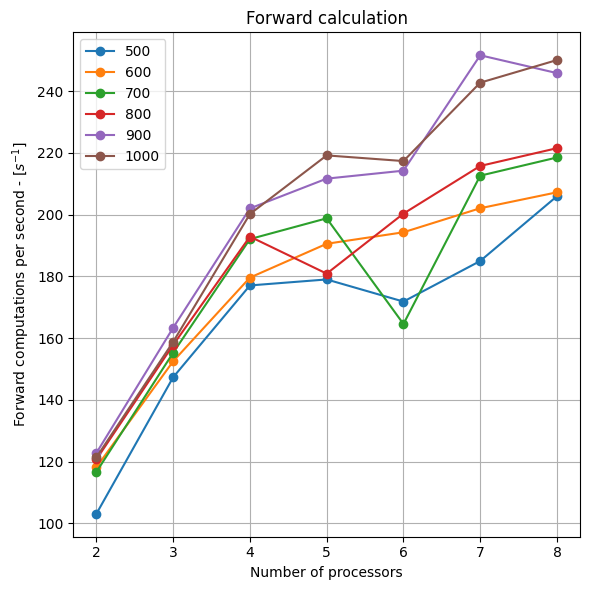

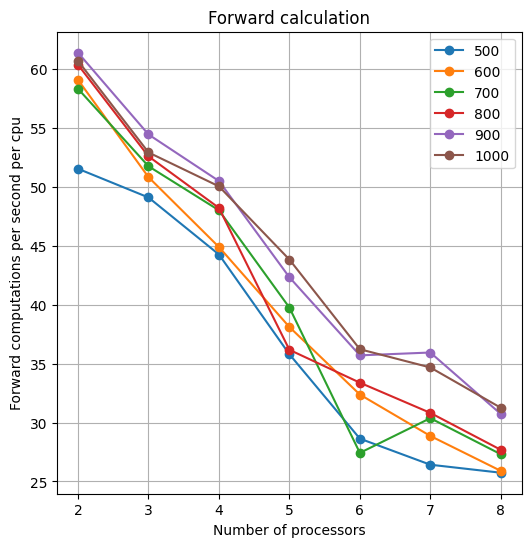

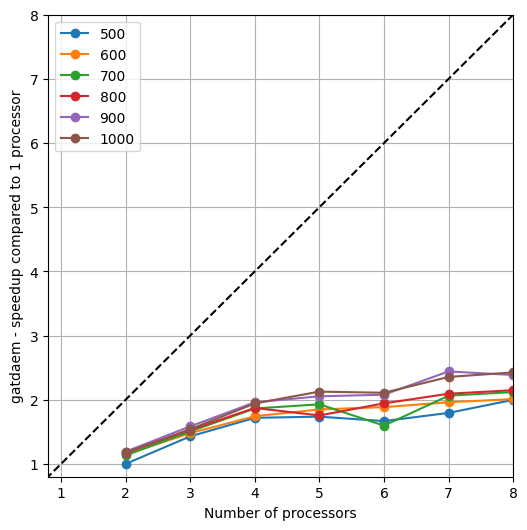

In [8]:

# Average timer per sounding 
T_forward_sounding = T_forward/N_arr[:,np.newaxis]
T_forward_sounding_per_sec = N_arr[:,np.newaxis]/T_forward
T_forward_sounding_per_sec_per_cpu = T_forward_sounding_per_sec/Nproc_arr[np.newaxis,:]
T_forward_sounding_speedup = T_forward_sounding_per_sec/T_forward_sounding_per_sec[0,0]


plt.figure(figsize=(6,6))    
#plt.plot(Nproc_arr, T_forward_sounding.T, 'o-')
#plt.plot(Nproc_arr, T_forward.T, 'o-')
plt.loglog(Nproc_arr, T_forward.T, 'o-', label='A')
# plot line 
plt.ylabel(r'TIME - $[s]$')
plt.xlabel('Number of processors')
plt.title('Forward calculation')
plt.grid()
plt.legend(N_arr, loc='upper left')
plt.ylim(1e-1, 1e+4)
plt.tight_layout()
plt.savefig('%s_forward_sec' % file_out)

plt.figure(figsize=(6,6))    
plt.plot(Nproc_arr, T_forward_sounding_per_sec.T, 'o-')
# plot line 
plt.ylabel(r'Forward computations per second - $[s^{-1}]$')
plt.xlabel('Number of processors')
plt.title('Forward calculation')
plt.grid()
plt.legend(N_arr)
plt.tight_layout()
plt.savefig('%s_forward_sounding_per_sec' % file_out)

plt.figure(figsize=(6,6))    
plt.plot(Nproc_arr, T_forward_sounding_per_sec_per_cpu.T, 'o-')
plt.ylabel('Forward computations per second per cpu')
plt.xlabel('Number of processors')
plt.title('Forward calculation')
plt.grid()
plt.legend(N_arr)
plt.savefig('%s_forward_sounding_per_sec_per_cpu' % file_out)

plt.figure(figsize=(6,6))    
plt.plot(Nproc_arr, T_forward_sounding_speedup.T, 'o-')
# plot a line from 0,0 tp Nproc_arr[-1], Nproc_arr[-1]
plt.plot([0, Nproc_arr[-1]], [0, Nproc_arr[-1]], 'k--')
# set xlim to 1, Nproc_arr[-1]
plt.xlim(.8, Nproc_arr[-1])
plt.ylim(.8, Nproc_arr[-1])
plt.ylabel('gatdaem - speedup compared to 1 processor')
plt.xlabel('Number of processors')
plt.grid()
plt.legend(N_arr)
plt.savefig('%s_forward_speedup' % file_out)



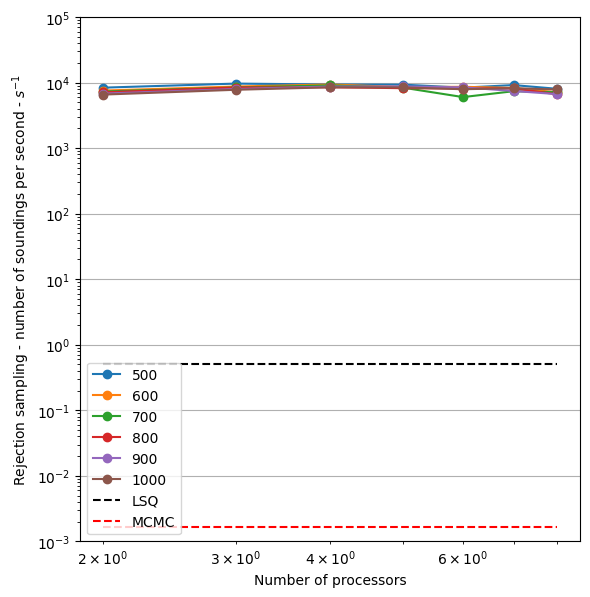

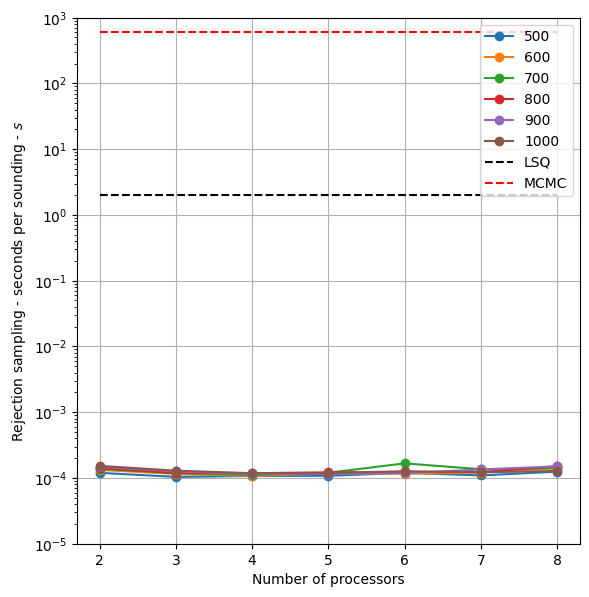

In [9]:
# Average timer per sounding
T_rejection_sounding = T_rejection/N_arr[:,np.newaxis]
T_rejection_sounding_per_sec = N_arr[:,np.newaxis]/T_rejection
T_rejection_sounding_per_sec_per_cpu = T_rejection_sounding_per_sec/Nproc_arr[np.newaxis,:]
T_rejection_sounding_speedup = T_rejection_sounding_per_sec/T_rejection_sounding_per_sec[0,0]
T_rejection_sounding_speedup = T_rejection_sounding_per_sec*0

T_rejection_per_data = nobs/T_rejection

for i in range(len(N_arr)):
    # find index of first valiue in T_rejection_sounding_per_sec[i,:] that is not nan
    idx = np.where(~np.isnan(T_rejection_sounding_per_sec[i,:]))[0][0]
    T_rejection_sounding_speedup[i,:] = T_rejection_sounding_per_sec[i,:]/(T_rejection_sounding_per_sec[i,idx]/Nproc_arr[idx]) 

plt.figure(figsize=(6,6))
plt.loglog(Nproc_arr, T_rejection_per_data.T, 'o-', label=N_arr)
plt.plot([Nproc_arr[0], Nproc_arr[-1]], [1./t_lsq, 1./t_lsq], 'k--', label='LSQ')
plt.plot([Nproc_arr[0], Nproc_arr[-1]], [1./t_mcmc, 1./t_mcmc], 'r--', label='MCMC')
plt.ylabel('Rejection sampling - number of soundings per second - $s^{-1}$')
plt.xlabel('Number of processors')
plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()
plt.ylim(1e-3, 1e+5)
plt.savefig('%s_rejection_sound_per_sec' % file_out)

plt.figure(figsize=(6,6))
plt.semilogy(Nproc_arr, 1./T_rejection_per_data.T, 'o-', label=N_arr)
#plt.plot(Nproc_arr, 1./T_rejection_per_data.T, 'o-', label=N_arr)
plt.plot([Nproc_arr[0], Nproc_arr[-1]], [t_lsq, t_lsq], 'k--', label='LSQ')
plt.plot([Nproc_arr[0], Nproc_arr[-1]], [t_mcmc, t_mcmc], 'r--', label='MCMC')
plt.ylabel('Rejection sampling - seconds per sounding - $s$')
plt.xlabel('Number of processors')
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.ylim(1e-5, 1e+3)
plt.savefig('%s_rejection_sec_per_sound' % file_out)

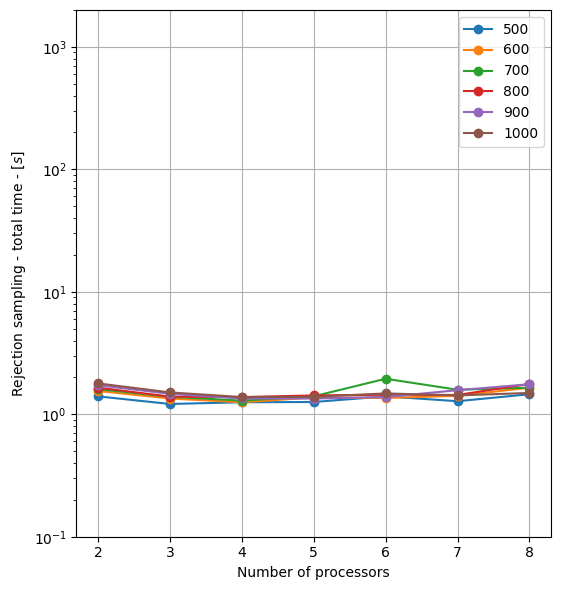

In [10]:
plt.figure(figsize=(6,6))
#plt.loglog(Nproc_arr, T_rejection.T, 'o-')
plt.semilogy(Nproc_arr, T_rejection.T, 'o-')
plt.ylabel('Rejection sampling - total time - $[s]$')
plt.xlabel('Number of processors')
plt.grid()
plt.legend(N_arr)
plt.tight_layout()
plt.ylim(1e-1, 2e+3)
plt.savefig('%s_rejection_time' % file_out)

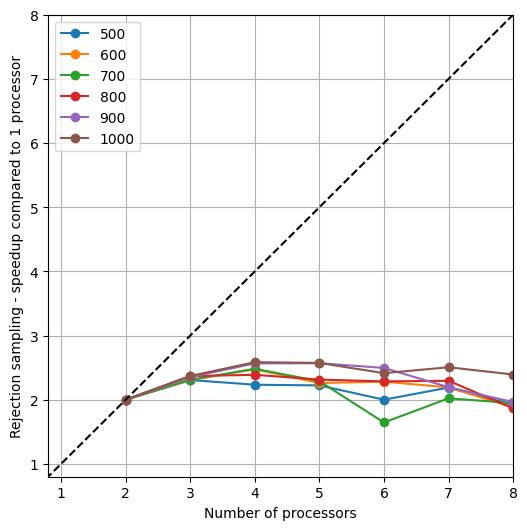

In [11]:
plt.figure(figsize=(6,6))
plt.plot(Nproc_arr, T_rejection_sounding_speedup.T, 'o-')
# plot a line from 0,0 tp Nproc_arr[-1], Nproc_arr[-1]
plt.plot([0, Nproc_arr[-1]], [0, Nproc_arr[-1]], 'k--')
# set xlim to 1, Nproc_arr[-1]
plt.xlim(.8, Nproc_arr[-1])
plt.ylim(.8, Nproc_arr[-1])
plt.ylabel('Rejection sampling - speedup compared to 1 processor')
plt.xlabel('Number of processors')
plt.grid()
plt.legend(N_arr)
plt.savefig('%s_rejection_speedup' % file_out)

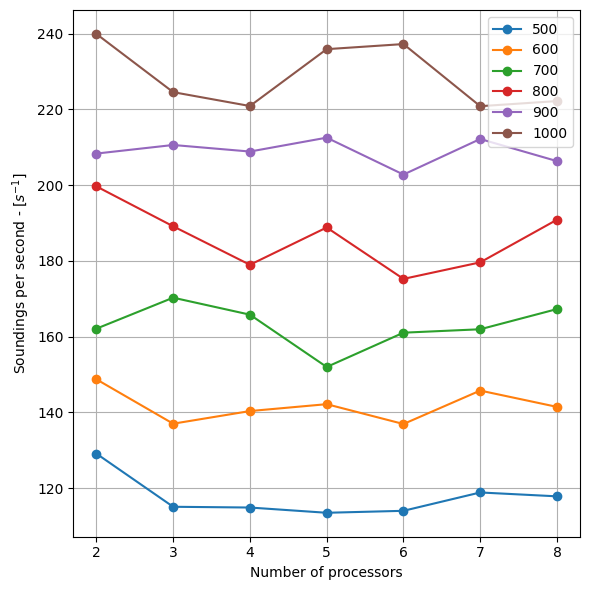

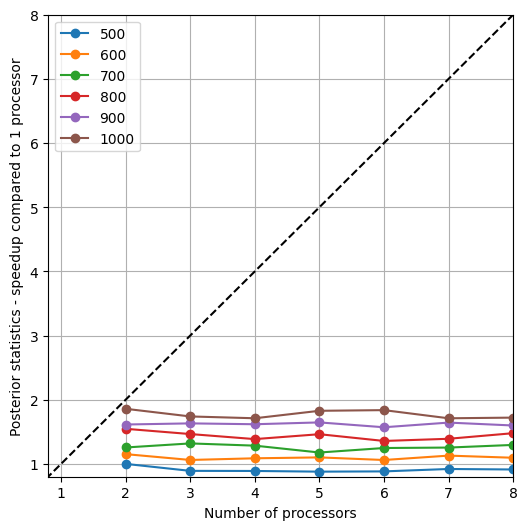

In [12]:
# Average timer per sounding
T_poststat_sounding = T_poststat/N_arr[:,np.newaxis]
T_poststat_sounding_per_sec = N_arr[:,np.newaxis]/T_poststat
T_poststat_sounding_per_sec_per_cpu = T_poststat_sounding_per_sec/Nproc_arr[np.newaxis,:]
T_poststat_sounding_speedup = T_poststat_sounding_per_sec/T_poststat_sounding_per_sec[0,0]

plt.figure(figsize=(6,6))
plt.plot(Nproc_arr, T_poststat_sounding_per_sec.T, 'o-')
plt.ylabel('Soundings per second - $[s^{-1}]$')
plt.xlabel('Number of processors')
plt.grid()
plt.legend(N_arr)
plt.tight_layout()
plt.savefig('%s_poststat_sounding_per_sec' % file_out)

plt.figure(figsize=(6,6))
plt.plot(Nproc_arr, T_poststat_sounding_speedup.T, 'o-')
# plot a line from 0,0 tp Nproc_arr[-1], Nproc_arr[-1]
plt.plot([0, Nproc_arr[-1]], [0, Nproc_arr[-1]], 'k--')
# set xlim to 1, Nproc_arr[-1]
plt.xlim(.8, Nproc_arr[-1])
plt.ylim(.8, Nproc_arr[-1])
plt.ylabel('Posterior statistics - speedup compared to 1 processor')
plt.xlabel('Number of processors')
plt.grid()
plt.legend(N_arr)
plt.savefig('%s_poststat_speedup' % file_out)


## Plot Cumulative Time useage for min and max number of used cores

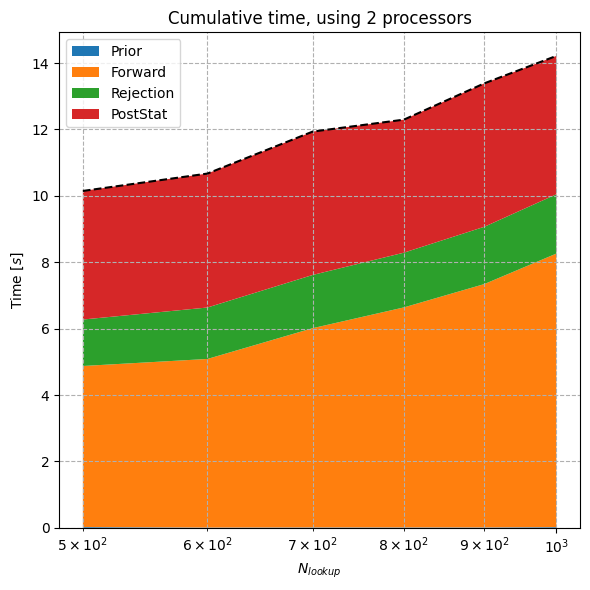

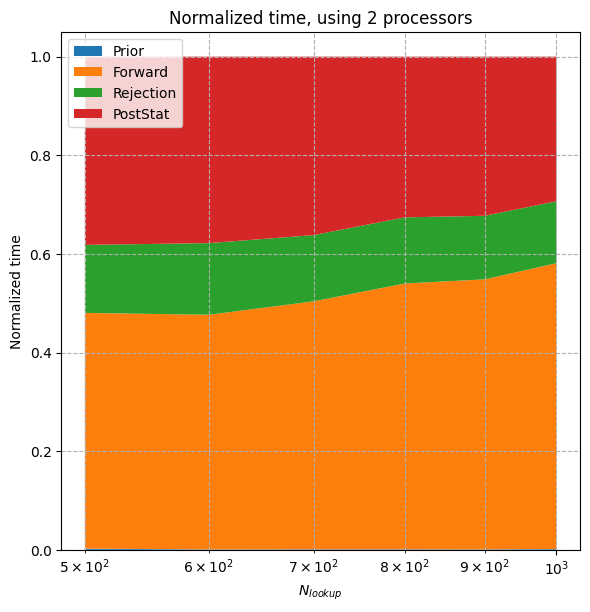

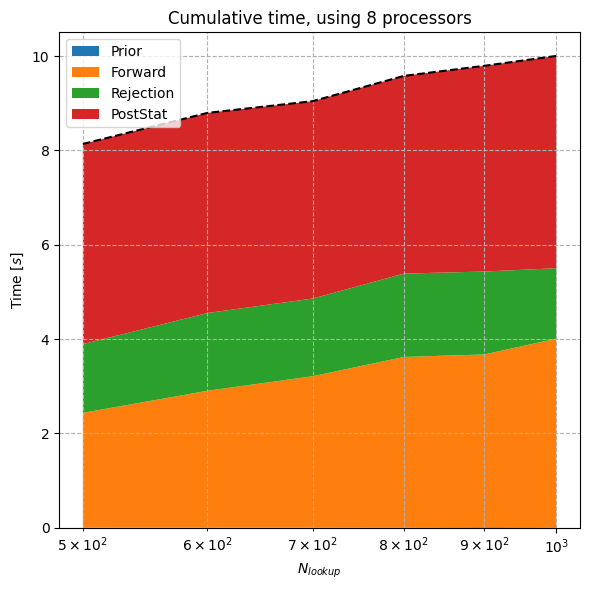

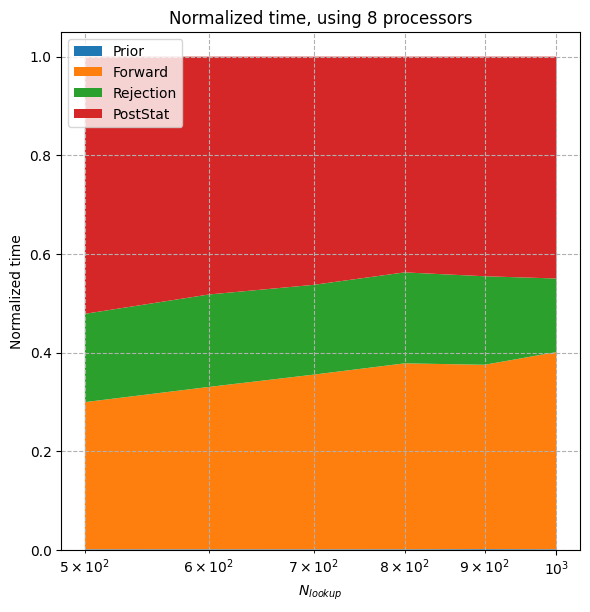

In [16]:
i_proc = len(Nproc_arr)-1
#i_proc= 0

for i_proc in [0,len(Nproc_arr)-1]:

    T=[T_prior[:,i_proc], T_forward[:,i_proc], T_rejection[:,i_proc], T_poststat[:,i_proc]]

    #%% Plor cumT as an area plot
    plt.figure(figsize=(6,6))
    plt.stackplot(N_arr, T, labels=['Prior', 'Forward', 'Rejection', 'PostStat'])
    plt.plot(N_arr, T_total[:, i_proc], 'k--')
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('$N_{lookup}$')
    plt.ylabel('Time [$s$]')
    plt.title('Cumulative time, using %d processors' % Nproc_arr[i_proc])
    plt.legend(loc='upper left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig('%s_Ncpu%d_cumT' % (file_out,Nproc_arr[i_proc]))

    # The same as thea area plot but normalized to the total time
    plt.figure(figsize=(6,6))
    plt.stackplot(N_arr, T/np.sum(T, axis=0), labels=['Prior', 'Forward', 'Rejection', 'PostStat'])
    plt.xscale('log')
    plt.xlabel('$N_{lookup}$')
    plt.ylabel('Normalized time')
    plt.legend(loc='upper left')
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.title('Normalized time, using %d processors' % Nproc_arr[i_proc])
    plt.savefig('%s_Ncpu%d_cumT_norm' % (file_out,Nproc_arr[i_proc]))



In [14]:
Nproc_arr[i_proc]

8